In [1]:
import pandas as pd
from pandas import DataFrame, Series
from matplotlib.lines import Line2D
import PyPDF2
from PyPDF2 import PdfFileReader
import math
import requests
import regex as re
import datetime
import matplotlib 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import numpy as np
from datetime import datetime

In [2]:
plt.rcParams['font.size']=13

In [3]:
meeting = DataFrame(pd.read_csv("Board Committee Commission Meeting Data.csv"))
agendas = meeting['Agenda_Link']
notes = meeting['Minutes_Link']

In [4]:
for i in range(len(meeting)):
    new = re.sub(r"\s", "", meeting['Meeting_ID'][i])
    meeting['Meeting_ID'][i] = new

<ipython-input-4-77a6d85d7f34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meeting['Meeting_ID'][i] = new


In [5]:
meeting['Duration_minutes'] = meeting['Duration'] #copy a column so that I have one to replace with the cell below

In [6]:
for i in range(len(meeting['Duration'])):
    time = re.split(':',meeting['Duration'][i])
    time = [int(x) for x in time]
    seconds = time[0]*60 + time[1] + time[2]/60
    meeting.iloc[i,10] = seconds

In [7]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_agendas/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['text']=text_list





In [8]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_notes/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['note_text']=text_list

Plotting Participants

In [9]:
meeting['Participants'].describe()

count    155.000000
mean      56.019355
std       51.616904
min        9.000000
25%       25.000000
50%       39.000000
75%       65.000000
max      337.000000
Name: Participants, dtype: float64

8683


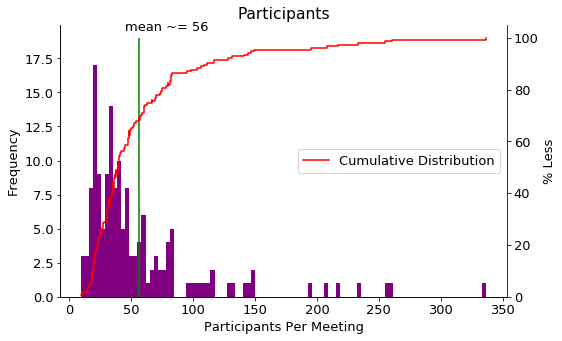

In [10]:
fig, ax = plt.subplots(figsize =(8,5))
ax.hist(x=meeting['Participants'], bins=100, color='purple', label = 'Frequency')
ax.set_ylabel("Frequency")
ax.set_xlabel("Participants Per Meeting")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(meeting['Participants'].mean(),0,19, color='green')
ax.text(45, 19.5, 'mean ~= 56')
ax.set_title('Participants')

def make_cdf(vals):
    s = pd.Series(sorted(vals))
    s = s.sort_values()
    return pd.Series(100*(s.index+1)/len(s), index=s.values)
cdf = make_cdf(meeting['Participants'])
ax2 = ax.twinx()
ax2.spines['top'].set_visible(False)
ax2.set_ylabel("% Less")


#ax = cdf.plot.line(ylim=0, color="red", ax=ax) # OK FOR LOTS OF DATA #ax = cdf.plot.line(ylim=0, color="red", drawstyle='steps-pre', ax=ax) # WRONG
cdf.plot.line(ylim=0, color="red", drawstyle='steps-post', ax=ax2, label= 'Cumulative Distribution') 
plt.legend(loc='center right')
plt.savefig('Participants.PDF',bbox_inches = "tight")

summ=0
for i in cdf.index:
    summ+=i
print(summ)

In [11]:
cdf[111]

90.3225806451613

Relationship between Duration and Participants

In [12]:
def get_xterms(x):
    t = pd.DataFrame({"x":x})
    t['logx'] = np.log(t['x'])
    t['log2x'] = np.log2(t['x'])
    return t

Meeting Duration ~= 0.8032078218393924*x + 23.783918063987635*logx + 34.312940643824405*log2x + -122.1002619985567


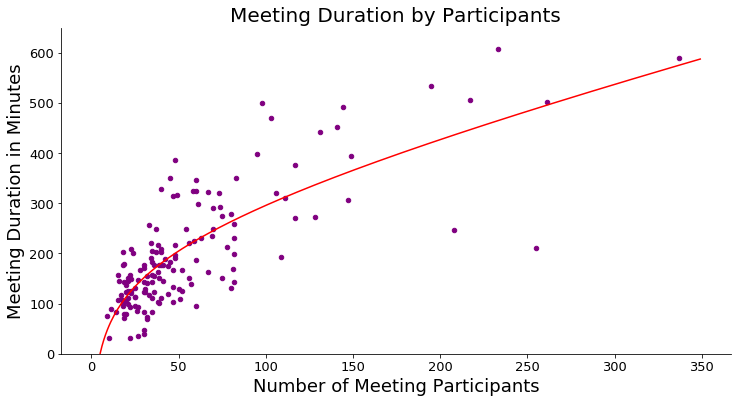

In [15]:
fig, ax = plt.subplots(figsize = (12,6))
meeting.plot.scatter(y='Duration_minutes', x = 'Participants', ax=ax, color='purple')
ax.set_ylabel("Meeting Duration in Minutes",size=18)
ax.set_xlabel("Number of Meeting Participants",size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Meeting Duration by Participants',size=20)
ax.set_ylim(0,650)

lr_v1 = LinearRegression()
poly_df_v1=get_xterms(meeting['Participants'])
lr_v1.fit(poly_df_v1, meeting[['Duration_minutes']])
x = np.arange(0.1,350,1)
ax.plot(x, lr_v1.predict(get_xterms(x)),'r')

# print(lr.coef_,lr.intercept_)
# plt.savefig('meeting_participants.png')

def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*{} + ".format(reg.coef_[0,i], columns[i])
    rv += str(lr_v1.intercept_[0])
    return rv

print("Meeting Duration ~= " + formula(lr_v1, poly_df_v1.columns))
plt.savefig('meeting_participants.PDF',bbox_inches = "tight")

**Switching the X and Y axes and fitting with power function**

In [16]:
from sklearn.linear_model import LinearRegression as LR

df = meeting[['Duration_minutes','Participants']]

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)
columns = ["Duration_minutes"]
arr = poly.fit_transform(df[columns])
poly_df = pd.DataFrame(arr)
poly_df = pd.DataFrame(arr, columns=poly.get_feature_names(columns))
poly_df

,Duration_minutes,Duration_minutes^2
0,167.916667,28196.006944
1,588.600000,346449.960000
2,129.000000,16641.000000
3,176.133333,31022.951111
4,278.900000,77785.210000
...,...,...
150,150.833333,22750.694444
151,248.483333,61743.966944
152,148.183333,21958.300278
153,169.450000,28713.302500


In [18]:
lr = LR()
lr.fit(poly_df, df[["Participants"]])
lr.coef_, lr.intercept_

(array([[-0.01439711,  0.00063873]]), array([25.41391953]))

Meeting Duration ~= -0.0143971116*Duration_minutes + 0.0006387333*Duration_minutes^2 + 25.4139195339048


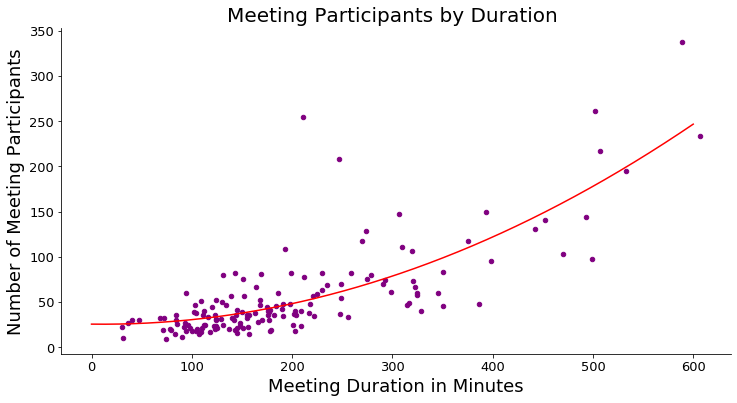

In [19]:
fig, ax = plt.subplots(figsize = (12,6))
df.plot.scatter(x="Duration_minutes", y="Participants", color="purple", ax=ax)
ax.set_xlabel("Meeting Duration in Minutes",size=18)
ax.set_ylabel("Number of Meeting Participants",size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Meeting Participants by Duration ',size=20)


# compute coords along fit line, then plot it
fit_x = np.arange(0, 600, 0.1).reshape(-1,1)
fit_y = lr.predict(poly.fit_transform(fit_x))
ax.plot(fit_x, fit_y, "red")

def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*{} + ".format(round(reg.coef_[0,i],10), columns[i])
    rv += str(lr.intercept_[0])
    return rv

print("Meeting Duration ~= " + formula(lr, poly_df.columns))
plt.savefig('meeting_participants.PDF',bbox_inches = "tight")

In [20]:
from sklearn.model_selection import train_test_split

In [93]:
test_df = poly_df.copy().copy()
test_df['Participants']=meeting['Participants']

train, test = train_test_split(test_df)
lr_v1 = linear_model.LinearRegression()
lr_v1.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
print("Training Score: ",lr_v1.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
 "Testing Score: ", lr_v1.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))





Training Score:  0.7184593265634438 
Testing Score:  0.4175847194008736


**EXPLAINED VARIANCE**

In [52]:
import sklearn
from sklearn import *

In [94]:
sklearn.metrics.explained_variance_score(test_df['Participants'],lr_v1.predict(poly_df))

0.611562831054366

**Coding Dates**

In [54]:
dates = []
starting = []
for i in meeting['Zoom_Meeting_Start_Time']:
    unformatted = i.split()[0]
    time = i.split()[1]
    datetime = datetime.strptime(unformatted , '%m/%d/%Y')
    time_start = datetime.strptime(time , '%H:%M')
    dates.append(datetime)
    starting.append(time_start)


In [55]:
day_of_week = [x.strftime("%A") for x in dates]
day_of_week_coded = [x.strftime("%w") for x in dates]
meeting['day_of_week']=day_of_week
meeting['day_of_week_coded']=day_of_week_coded

In [56]:
meeting.head()

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Duration_minutes,text,note_text,day_of_week,day_of_week_coded
0,954410442,CCEC,4:30:00 PM,3/31/2020 15:40,6:27 PM,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,167.917,COMMON COUNCIL EXECUTIVE COMMITTEECity of Madi...,"City of MadisonMadison, WI 53703www.cityofmad...",Tuesday,2
1,531697510,Common Council,6:30:00 PM,3/31/2020 17:04,02:53 AM(Next day),9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,588.6,COMMON COUNCILCity of MadisonAgenda - AmendedC...,"City of MadisonMadison, WI 53703www.cityofmad...",Tuesday,2
2,411578576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,4/6/2020 15:40,5:49 PM,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,129,FINANCE COMMITTEECity of MadisonAgenda - Appro...,"City of MadisonMadison, WI 53703www.cityofmad...",Monday,1
3,563608269,"CCEC: Meeting of April 9, 2020",6:00:00 PM,4/9/2020 16:57,7:53 PM,2:56:08,36,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,176.133,COMMON COUNCIL EXECUTIVE COMMITTEECity of Madi...,"City of MadisonMadison, WI 53703www.cityofmad...",Thursday,4
4,468948855,"Plan Commission: Meeting of April 13, 2020",5:30:00 PM,4/13/2020 16:35,9:14 PM,4:38:54,80,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,278.9,PLAN COMMISSIONCity of MadisonAgenda - Approve...,"City of MadisonMadison, WI 53703www.cityofmad...",Monday,1


Time of Day and Starting Hour

In [57]:
meeting['starting_formatted']=[int(x.strftime("%H")) for x in starting]
meeting['starting_formatted_normal']=[int(x.strftime("%-I")) for x in starting]

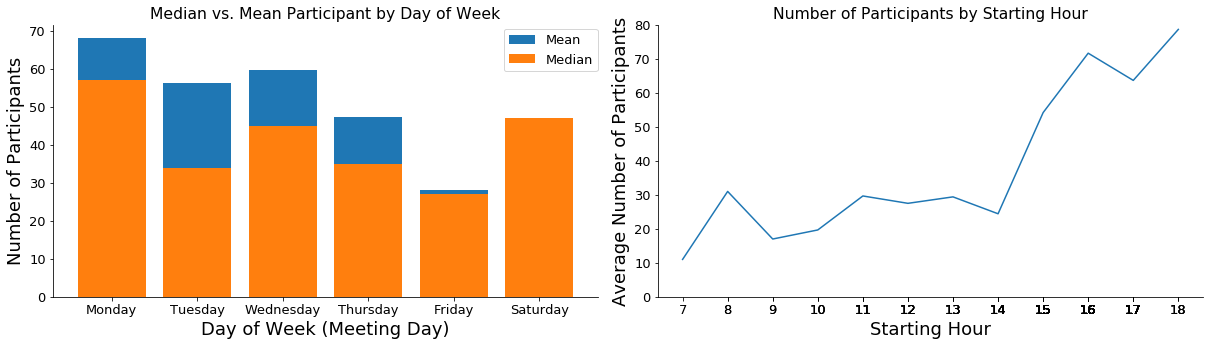

In [58]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(17,5))
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_week_df = DataFrame(data = {
    'median':meeting.groupby('day_of_week',sort=False).median()['Participants'],
    'mean':meeting.groupby('day_of_week',sort=False).mean()['Participants']
})

day_week_df = day_week_df.reindex(cats)
day_week_df= day_week_df.reset_index()

ax[0].bar(x=day_week_df['day_of_week'] , height=day_week_df['mean'],label="Mean")
ax[0].bar(x=day_week_df['day_of_week'] , height=day_week_df['median'],label="Median")
fig.legend(loc="upper center",ncol=1, bbox_to_anchor=(0.45,.9))

ax[0].set_xlabel("Day of Week (Meeting Day)",size=18)
ax[0].set_ylabel("Number of Participants",size=18)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title('Median vs. Mean Participant by Day of Week')

ax[1].set_ylabel("Average Number of Participants",size=18)
ax[1].set_xlabel("Meeting Starting Hour",size=18)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title('Number of Participants by Starting Hour')

# participant_df = meeting[['starting_formatted','Participants']]
# participant_df.groupby('starting_formatted').mean().plot.bar(ax=ax)
# plotting = participant_df.groupby('starting_formatted').mean().reset_index()
# ax[1].bar(plotting['starting_formatted'],plotting['Participants'])

participant_df = meeting[['starting_formatted','Participants']]
# participant_df.groupby('starting_formatted').mean().plot.bar(ax=ax)
plotting = participant_df.groupby('starting_formatted').mean()
DataFrame({"participants":plotting['Participants'] }).plot.line(ax=ax[1])
ax[1].set_ylim(0,80)
ax[1].set_xlabel('Starting Hour')
plt.xticks(meeting['starting_formatted'])
ax[1].get_legend().remove()

plt.xticks(meeting['starting_formatted'])

# plt.savefig('participant_v_start.png',bbox='tight')

plt.tight_layout()


plt.savefig('meetin_by_day.PDF',bbox='tight')



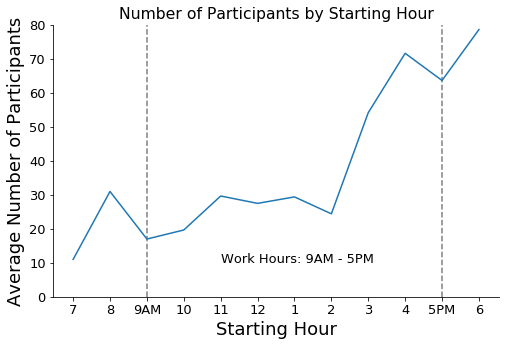

In [59]:
fig, ax = plt.subplots(figsize=(8,5))


ax.set_ylabel("Average Number of Participants",size=18)
ax.set_xlabel("Meeting Starting Hour",size=18)
ax.vlines(17, 0, 80, color='grey',linestyle='--')
ax.vlines(9, 0, 80, color='grey',linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Number of Participants by Starting Hour')

participant_df = meeting[['starting_formatted','Participants']]
# participant_df.groupby('starting_formatted').mean().plot.bar(ax=ax)
plotting = participant_df.groupby('starting_formatted').mean()
DataFrame({"participants":plotting['Participants'] }).plot.line(ax=ax)
ax.set_ylim(0,80)
ax.set_xlabel('Starting Hour')
plt.xticks(np.arange(7,19,1))
ax.get_legend().remove()
ax.text(11,10,'Work Hours: 9AM - 5PM')

labels = ["7","8","9AM","10","11","12","1","2","3","4","5PM","6"]
ax.set_xticklabels(labels)


plt.savefig('participants_by_hour.PDF')


In [60]:
all_days_df = day_week_df.append(pd.DataFrame([['Sunday', 0,0]], columns=['day_of_week','median','mean']))

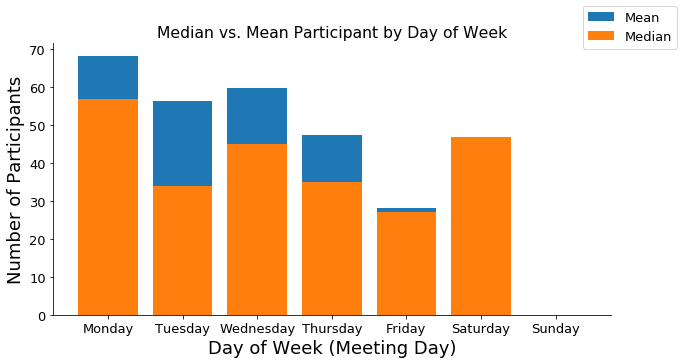

In [61]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x=all_days_df['day_of_week'] , height=all_days_df['mean'],label="Mean")
ax.bar(x=all_days_df['day_of_week'] , height=all_days_df['median'],label="Median")
fig.legend(loc="upper right",ncol=1)

ax.set_xlabel("Day of Week (Meeting Day)",size=18)
ax.set_ylabel("Number of Participants",size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Median vs. Mean Participant by Day of Week')
plt.savefig('day_of_week.PDF')

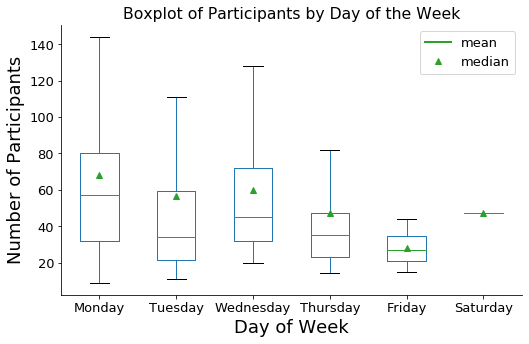

In [91]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
fig, ax = plt.subplots(figsize=(8,5))
meeting.boxplot(column='Participants', by='day_of_week', showfliers=False, positions=[5,1,6,4,2,3],showmeans=True,ax=ax, grid=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Day of Week', size =18)
ax.set_ylabel('Number of Participants', size =18)
ax.set_title('Boxplot of Participants by Day of the Week')
fig.suptitle('')

lines = [Line2D([0], [0], color='#2fa02c', linewidth=2, linestyle='-'), Line2D([], [], color='#2fa02c', marker='^', linestyle='None')]
labels = ['mean', 'median']
plt.legend(lines,labels)



plt.savefig('day_of_week_box.PDF')

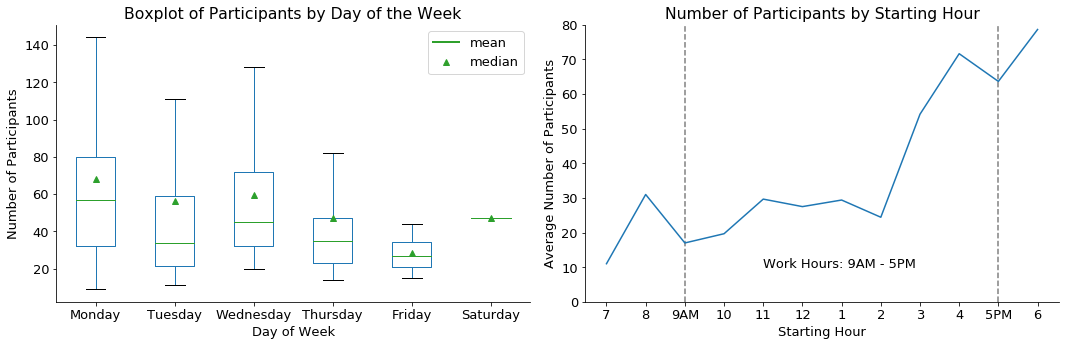

In [63]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,5))

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

meeting.boxplot(column='Participants', by='day_of_week', showfliers=False, positions=[5,1,6,4,2,3],showmeans=True, grid=False, ax=ax[0])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Number of Participants')
ax[0].set_title('Boxplot of Participants by Day of the Week')
fig.suptitle('')
lines = [Line2D([0], [0], color='#2fa02c', linewidth=2, linestyle='-'), Line2D([], [], color='#2fa02c', marker='^', linestyle='None')]
labels = ['mean', 'median']
ax[0].legend(lines,labels)

ax[1].set_ylabel("Average Number of Participants")
ax[1].set_xlabel("Meeting Starting Hour")
ax[1].vlines(17, 0, 80, color='grey',linestyle='--')
ax[1].vlines(9, 0, 80, color='grey',linestyle='--')

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title('Number of Participants by Starting Hour')

participant_df = meeting[['starting_formatted','Participants']]
# participant_df.groupby('starting_formatted').mean().plot.bar(ax=ax)
plotting = participant_df.groupby('starting_formatted').mean()
DataFrame({"participants":plotting['Participants'] }).plot.line(ax=ax[1])
ax[1].set_ylim(0,80)
ax[1].set_xlabel('Starting Hour')
plt.xticks(np.arange(7,19,1))
ax[1].get_legend().remove()
ax[1].text(11,10,'Work Hours: 9AM - 5PM')

labels = ["7","8","9AM","10","11","12","1","2","3","4","5PM","6"]
ax[1].set_xticklabels(labels)

# plt.savefig('participant_v_start.png',bbox='tight')

plt.tight_layout()


plt.savefig('meetin_by_day.PDF',bbox='tight')




# Playing with Multiple Regression Predicting No. of Participants

Number of Agenda Items

In [64]:
import re
import pdfminer
from subprocess import check_output
from bs4 import BeautifulSoup
from collections import defaultdict

In [65]:
def find_near(x, y):
    for x_ in range(x-5, x+5):
        for y_ in range(y-5, y+5):
            if (x_, y_) in text:
                return text[(x_, y_)]
    return None

meeting_id = meeting['Meeting_ID']
agenda_items = []
overall_list = []
for i in meeting_id:
    agenda_file = "pdf_agendas/" + i +".pdf"
    try:
        s = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", agenda_file])
    except Exception:
        agenda_items.append("N/A")
        overall_list.append("N/A")
        continue
    page = BeautifulSoup(s)

    text = {} # key=(x,y), val=text

    for div in page.find_all("div"): #gets a list of different div tags 
        style = div.attrs.get("style", "") #attrs will tell you the positioning
        m1 = re.search("left:(\d+)px", style)
        m2 = re.search("top:(\d+)px", style)
        if m1 and m2:
            x, y = int(m1.group(1)), int(m2.group(1))#each parenthesis is a different group
            text[(x,y)] = div.get_text()

    agenda_dict = {}
    rand_str = ""

    for (x,y), t in text.items():
        
        # agenda items are roughly at x=170
        if 165 < x < 175:
            # agenda numbers are rougly at x=69, same y as text
            num = find_near(69, y)
            if num and re.match('[0-9]+',num) != None:
                agenda_num = int(re.match('[0-9]+',num).group(0))
                agenda_dict[agenda_num] = t
                rand_str+=t
    agenda_items.append(agenda_dict)
    overall_list.append(rand_str)
    

In [66]:
meeting['agenda_num'] = overall_list
agenda_amount = [len(x) for x in agenda_items]
meeting['agenda_amount'] = agenda_amount

In [67]:
import copy

In [68]:
X_df = meeting[['agenda_amount','Duration_minutes','day_of_week_coded']].copy().copy()
time_block = []
for x in meeting['starting_formatted']:
    if 9<=x<=17:
        time_block.append(2)
    elif x >17:
        time_block.append(3)
    else:
        time_block.append(1)

In [69]:
X_df['starting_formatted']=time_block

In [70]:
X_df

,agenda_amount,Duration_minutes,day_of_week_coded,starting_formatted
0,7,167.917,2,2
1,116,588.6,2,2
2,6,129,1,2
3,2,176.133,4,2
4,22,278.9,1,2
...,...,...,...,...
150,3,150.833,3,2
151,2,248.483,4,2
152,5,148.183,4,2
153,1,169.45,4,2


# Playing around with Text Analysis

In [71]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk import corpus
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

Create a list of stop words

In [72]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [73]:
meeting['agenda_num']

0      Establishing a Body-Worn Camera Feasibility Re...
1      Commerating the 50th anniversary of Earth Day ...
2      A Resolution to authorize the noncompetitive p...
3      Discuss Council's Role & Response during COVID...
4      General Public Correspondence to the Plan Comm...
                             ...                        
150                                                  N/A
151    Plan Commission Public Comment Period\nPotenti...
152    PUBLIC COMMENT FOR THE 7/30/2020 MEETING OF TH...
153    Task Force Deliberation, Discussion, and Possi...
154    Fiduciary Investment Review:\n-Market Review\n...
Name: agenda_num, Length: 155, dtype: object

Pre-process the dataset to get a cleaned, normalized text corpus

In [74]:
meeting['note_text']

0      City of MadisonMadison, WI  53703www.cityofmad...
1      City of MadisonMadison, WI  53703www.cityofmad...
2      City of MadisonMadison, WI  53703www.cityofmad...
3      City of MadisonMadison, WI  53703www.cityofmad...
4      City of MadisonMadison, WI  53703www.cityofmad...
                             ...                        
150                                                  N/A
151    City of MadisonMadison, WI  53703www.cityofmad...
152    City of MadisonMadison, WI  53703www.cityofmad...
153    City of MadisonMadison, WI  53703www.cityofmad...
154                                                  N/A
Name: note_text, Length: 155, dtype: object

In [75]:
# Pre-process dataset to get a cleaned and normalised text corpus
corpus = []
meeting['note_text']
ds_count = len(meeting.agenda_num)
for i in range(0, ds_count):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(meeting['agenda_num'][i]))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Convert to list from string
    text = text.split()
    
    # Stemming
    ps=PorterStemmer()
    
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [76]:
# Tokenize the text and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

Extract most frequently occurring keywords and n-grams¶

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

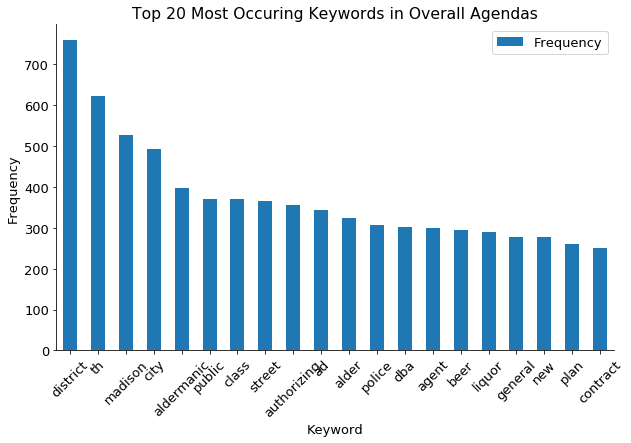

In [77]:
# View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot, save as CSV
top_words = get_top_n_words(corpus, n=20)
top_df = DataFrame(top_words)
top_df.columns=["Keyword", "Frequency"]
# print(top_df)
top_df.to_csv('_top_words.csv')

# Barplot of most freq words
# import seaborn as sns
# sns.set(rc={'figure.figsize':(13,8)})
fig, ax = plt.subplots(figsize = (10,6))
# top_df = top_df.drop([1])


top_df.plot.bar(x="Keyword",ax=ax)

ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Top 20 Most Occuring Keywords in Overall Agendas')
plt.xticks(rotation=45) 
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
# g.figure.savefig("_keyword.png", bbox_inches = "tight")
# plt.clf()

# plt.savefig('top20keywords.EPS')

BI-GRAMS

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


                Bi-gram  Frequency
0   aldermanic district        396
1        district alder        295
2                 th ad        277
3     class combination        222
4    combination liquor        222
5           liquor beer        222
6       madison general        194
7     general ordinance        194
8               llc dba        182
9            city clerk        177
10             ald dist        176
11        police sector        174
12         alcohol food        167
13      food aldermanic        164
14               th ald        149
15         beer alcohol        148
16         city madison        135
17      section madison        133
18    authorizing mayor        132
19          public work        132


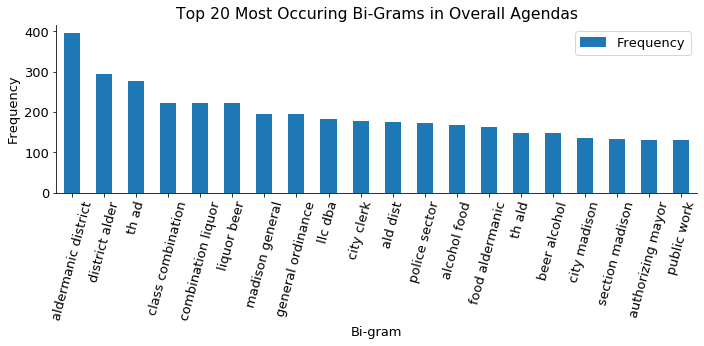

In [78]:
# Most frequently occuring bigrams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# Convert most freq bigrams to dataframe for plotting bar plot, save as CSV
top2_words = get_top_n2_words(corpus, n=20)
top2_df = DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Frequency"]
print(top2_df)
top2_df.to_csv( '_bigrams.csv')

# Barplot of most freq Bi-grams
# import seaborn as sns
# sns.set(rc={'figure.figsize':(13,8)})
fig, ax = plt.subplots(figsize = (10,5))
# h=plt.bar(x="Bi-gram", height="Frequency", data=top2_df)
# h.set_xticklabels(h.get_xticklabels(), rotation=75)
top2_df.plot.bar(x="Bi-gram",ax=ax)

ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Top 20 Most Occuring Bi-Grams in Overall Agendas')
plt.xticks(rotation=75) 
plt.tight_layout()
plt.savefig("bi-gram.EPS")

In [79]:
top_df
top_n_dict = {}
for i in range(len(top_df['Keyword'])):
#     print(top_df.iloc[i,1])
    if top_df.iloc[i,0]=='th':
        continue
    elif top_df.iloc[i,0]=='alder':
        top_n_dict['ad']+=top_df.iloc[i,1]
        continue
    elif top_df.iloc[i,0]=='liquor':
        top_n_dict['beer']+=top_df.iloc[i,1]
        continue
    elif top_df.iloc[i,0]=='contract':
        top_n_dict['plan']+=top_df.iloc[i,1]
        continue
    top_n_dict[top_df.iloc[i,0]]=top_df.iloc[i,1]
new_not_redundant_df = DataFrame({'Keyword':list(top_n_dict.keys()),'Frequency':list(top_n_dict.values())})
new_not_redundant_df=new_not_redundant_df.sort_values(by='Frequency',ascending=False)

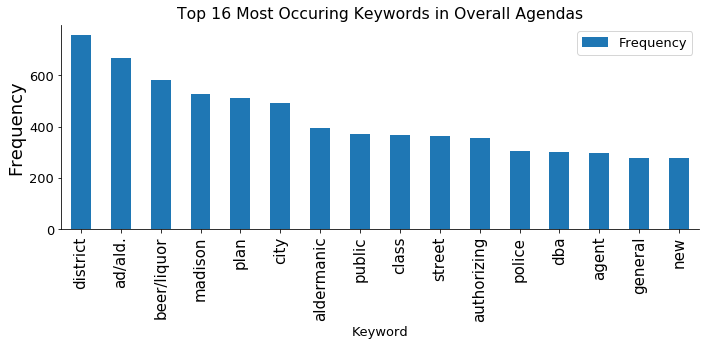

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
new_not_redundant_df.plot.bar(x="Keyword",ax=ax)
ax.set_ylabel("Frequency",size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Top '+ str(len(new_not_redundant_df)) +' Most Occuring Keywords in Overall Agendas')
# plt.xticks(rotation=45) 
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'ad/ald.'
labels[2] = 'beer/liquor'
ax.set_xticklabels(labels)
plt.xticks(size = 15)

plt.tight_layout()

plt.savefig('top16keywords.pdf', bbox='tight')

In [81]:
important_keys = list(new_not_redundant_df['Keyword'])
important_keys[1]='alder'
important_keys[2]='liquor'
new_not_redundant_df['New_Keywords']=important_keys

In [82]:
# top_20 = list(top_df.drop([1,8])['Keyword'])
for top_word in new_not_redundant_df['New_Keywords']:
    word_count=[]
    for text in meeting['note_text']:
        if top_word in text.lower().split():
            word_count.append(1)
        else:
            word_count.append(0)
    X_df[top_word]=word_count

In [83]:
y = meeting['Participants']
regr = linear_model.LinearRegression()
regr.fit(X_df, y)
agenda_numbers=0
Duration_minutes=50
day_of_week_coded=5
starting_coded=3
district =0
alder=0
liquor=0
madison =0
plan = 0
city= 0
aldermanic = 0
public = 0
class_=0 
street = 0
authorizing = 0
police = 0
dba =0
agent = 0
general =0
new = 0


predicted = regr.predict([[agenda_numbers,Duration_minutes,day_of_week_coded,starting_coded,district,alder, liquor, madison, plan, city, aldermanic, public, class_, street, authorizing, police, dba, agent, general, new]])






In [84]:
print('(Test Case) The number of Partipants will be around {} people \n'.format(predicted))

print("Keywords from agenda_num applied on agenda_num")


def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*{} + ".format(reg.coef_[i], columns[i])
    rv += str(reg.intercept_)
    return rv

print("Number of Participants ~= " + formula(regr, list(X_df.columns)))

(Test Case) The number of Partipants will be around [14.76658877] people 

Keywords from agenda_num applied on agenda_num
Number of Participants ~= 0.5128746403412587*agenda_amount + 0.3238188168264177*Duration_minutes + -0.5544219353373682*day_of_week_coded + 13.155425234560806*starting_formatted + -7.284155801266462*district + -7.724966966805531*alder + -9.420183519139917*liquor + 6.6103478764815975*madison + -9.788078320051836*plan + 6.610347876481599*city + 34.26871174183075*aldermanic + 11.995260684750756*public + -39.97983529667694*class + -8.004689742154655*street + -4.512454498635994*authorizing + 3.2927440497025233*police + -9.420183519139911*dba + -0.07461227873983683*agent + -21.751974408614007*general + -6.3383894240077465*new + -38.11851810215691


In [68]:
coef_df = DataFrame({'Column':list(X_df.columns), 'Coefficients':list(regr.coef_)})
coef_df.head()

,Column,Coefficients
0,agenda_amount,0.512875
1,Duration_minutes,0.323819
2,day_of_week_coded,-0.554422
3,starting_formatted,13.155425
4,district,-7.284156


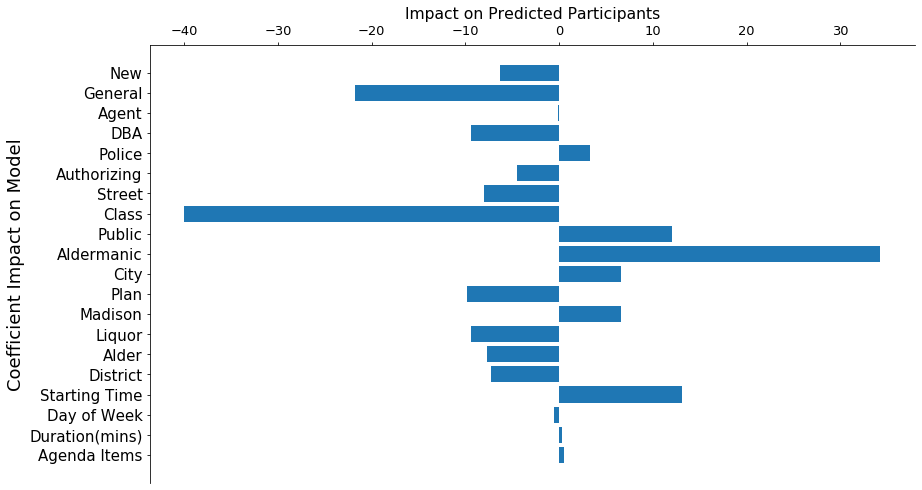

In [44]:
fig,ax=plt.subplots(figsize=(13,7))

coefficients = ['Agenda Items','Duration(mins)','Day of Week','Starting Time','District','Alder','Liquor','Madison','Plan','City','Aldermanic','Public','Class','Street','Authorizing','Police','DBA','Agent','General','New']
plt.barh(y=coefficients,width=coef_df['Coefficients'])
plt.xticks(rotation=45) 
plt.tight_layout()
plt.xticks(size = 15)
plt.yticks(size = 15)
ax.xaxis.tick_top()

ax.set_ylabel("Coefficient Impact on Model",size=18)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_title('Impact on Predicted Participants')
plt.tight_layout()


plt.savefig('coefficients.PDF')

K-Means

In [45]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)

In [46]:
kmean_df = meeting[['Duration_minutes','Participants']]
kmean_df

,Duration_minutes,Participants
0,167.917,52
1,588.6,337
2,129,31
3,176.133,36
4,278.9,80
...,...,...
150,150.833,21
151,248.483,54
152,148.183,23
153,169.45,81


In [47]:
Kmean.fit(kmean_df)
y_kmeans = Kmean.predict(kmean_df)

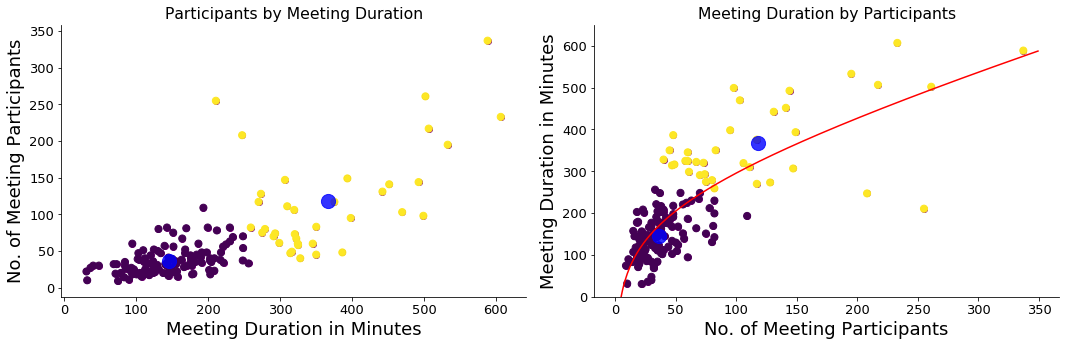

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2 ,figsize = (15,5))
ax[0].scatter(x='Duration_minutes', y = 'Participants', color='purple',data=meeting)
ax[0].set_xlabel("Meeting Duration in Minutes",size = 18)
ax[0].set_ylabel("No. of Meeting Participants",size = 18)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title('Participants by Meeting Duration')
ax[0].scatter(kmean_df['Duration_minutes'], kmean_df['Participants'], c=y_kmeans, s=50, cmap='viridis')
centers = Kmean.cluster_centers_
ax[0].scatter(centers[:, 0], centers[:, 1], c='blue', s=200, alpha=.8);


ax[1].scatter(x='Participants', y = 'Duration_minutes', color='purple',data=meeting)
ax[1].set_ylabel("Meeting Duration in Minutes",size = 18)
ax[1].set_xlabel("No. of Meeting Participants",size = 18)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title('Meeting Duration by Participants')
ax[1].set_ylim(0,650)
ax[1].scatter( kmean_df['Participants'],kmean_df['Duration_minutes'], c=y_kmeans, s=50, cmap='viridis')
centers = Kmean.cluster_centers_
ax[1].scatter( centers[:, 1],centers[:, 0], c='blue', s=200, alpha=.8);

lr = LinearRegression()
poly_df=get_xterms(meeting['Participants'])
lr.fit(poly_df, meeting[['Duration_minutes']])
x = np.arange(0.1,350,1)
ax[1].plot(x, lr.predict(get_xterms(x)),'r')
plt.tight_layout()


plt.savefig('participants_vs_duration.PDF', bbox='tight')

# Working with Committee - UPDATED MULTIPLE REGRESSION

In [86]:
committee = ['Common Council Executive Committee',
 'Common Council Executive Committee',
 'Finance Committee',
 'Common Council Executive Committee',
 'Plan Commission',
 'Transportation Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Plan Commission',
 'Finance Committee',
 'Urban Design Commission',
 'Landmarks Commission',
 'MATPB',
 'Common Council Executive Committee',
 'Food Policy Council',
 'MATPB',
 'Plan Commission',
 'Finance Committee',
 'Transportation Commission',
 'Board of Park Commissioners',
 'Monona Terrace Community & Convention Center Board',
 'Common Council Executive Committee',
 'Plan Commission',
 'Task Force on Golf in Madison Parks',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Zoning Board of Appeals',
 'Common Council Executive Committee',
 'Urban Design Commission',
 'Alcohol License Review Committee',
 'Alcohol License Review Committee',
 'Room Tax Commission',
 'Landmarks Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Madison Food Policy Council',
 'Community Development Block Grant Committee',
 'Madison Public Library Board',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Complete Count Committee',
 'Finance Committee',
 'Public Safety Review Committee',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'CDA Board',
 'Equal Opportunities Commission',
 'Common Council Executive Committee',
 'Transportation Policy and Planning Board',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Economic Development Committee',
 'Alcohol License Review Committee',
 'MATPB',
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'PSRC',
 'Finance Committee',
 'PSRC',
 'Sustainable Madison Committee',
 'Water Utility Board',
 'MATPB',
 'Transportation Commission',
 'Community Services Committee',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Common Council Executive Committee',
 'Monona Terrace Community & Convention Center Board',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Task Force on Golf in Madison Parks',
 'Monona Terrace Community & Convention Center Board',
 'Madison Food Policy Council',
 'Downtown Coordinating Committee',
 'Landlord and Tenant Issues Committee',
 'Madison Food Policy Council',
 'Urban Design Commission',
 'MATPB',
 'PSRC',
 'Body-Worn Camera Feasibility Review Committee',
 'Madison Public Library Board',
 'Affirmative Action Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Transportation Policy and Planning Board',
 'PSRC',
 'Room Tax Commission',
 'Madison Food Policy Council',
 'Madison Arts Commission',
 'Board of Public Works',
 'Public Safety Review Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Madison Food Policy Council',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'Community Development Authority Board',
 'Madison Public Library Board',
 'Equal Opportunities Commission',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Traffic Calming Subcommittee',
 'Landmarks Commission',
 'Plan Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'City-Wide Violence Meeting',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'PSRC',
 'Transportation Policy and Planning Board',
 'Alcohol License Review Committee',
 'Task Force on Golf in Madison Parks',
 'PSRC',
 "President's Work Group on Council Communication Tools & Processes",
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'CDBG Committee',
 'Traffic Calming Subcommittee',
 'Body-Worn Camera Feasibility Review Committee',
 'Finance Committee',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Personnel Board',
 'Board of Public Works',
 'Transportation Commission',
 "President's Work Group on Council Communication Tools & Processes",
 'Madison Food Policy Council',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Task Force on Golf in Madison Parks',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Finance Committee',
 'Sustainable Madison Committee',
 'Plan Commission',
 'Water Utility Board',
 'Public Safety Review Committee',
 'Food Systems Recovery and Resilience Work Group',
 'Urban Design Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'MLK Commission',
 'Public Safety Review Committee',
 'Plan Commission',
 'Body-Worn Camera Feasibility Review Committee',
 'Task Force on Golf in Madison Parks',
 'Deferred Compensation Committee']

In [87]:
meeting['Committee']=committee

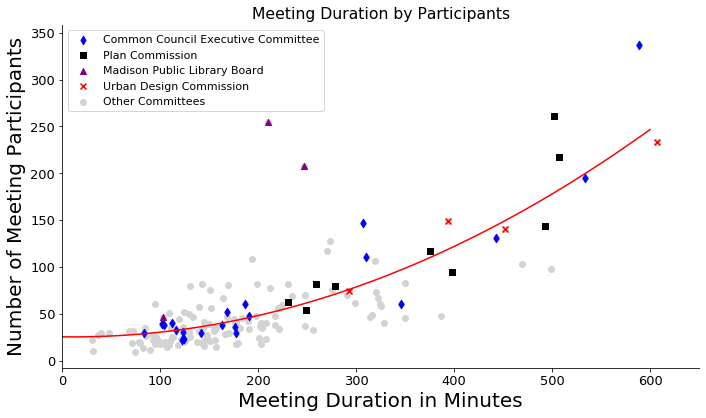

In [92]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Meeting Duration in Minutes", size=20)
ax.set_ylabel("Number of Meeting Participants", size=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Meeting Duration by Participants')
ax.set_xlim(0,650)

rest=plt.scatter(y=meeting['Participants'],x=meeting['Duration_minutes'], c = 'lightgrey')

just_exec = meeting[meeting['Committee']=='Common Council Executive Committee']
arr1=plt.scatter(y=just_exec['Participants'],x=just_exec['Duration_minutes'],c='blue', marker='d')

just_plan = meeting[meeting['Committee']=='Plan Commission']
arr2=plt.scatter(y=just_plan['Participants'],x=just_plan['Duration_minutes'],c='black', marker='s')

just_lib = meeting[meeting['Committee']=='Madison Public Library Board']
arr3=plt.scatter(y=just_lib['Participants'],x=just_lib['Duration_minutes'],c='purple', marker='^')

just_des = meeting[meeting['Committee']=='Urban Design Commission']
arr4=plt.scatter(y=just_des['Participants'],x=just_des['Duration_minutes'],c='red', marker='x')

plt.legend([arr1, arr2, arr3,arr4,rest], ['Common Council Executive Committee','Plan Commission','Madison Public Library Board','Urban Design Commission','Other Committees'], prop={'size': 11})
ax.plot(fit_x, fit_y, "red")

plt.tight_layout()


plt.savefig('participant_by_committee.PDF', bbox='tight')

Adding The Committees as a Categoral 

In [52]:
unique_committee = list(set(committee))

In [53]:
unique_committee

['Alcohol License Review Committee',
 'Food Policy Council',
 'Food Systems Recovery and Resilience Work Group',
 'Plan Commission',
 'CDBG Committee',
 'Community Development Authority Board',
 'Common Council Executive Committee',
 'City-Wide Violence Meeting',
 'Public Safety Review Committee',
 'Economic Development Committee',
 'Community Services Committee',
 'Traffic Calming Subcommittee',
 'CDA Board',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Downtown Coordinating Committee',
 'Urban Design Commission',
 'Monona Terrace Community & Convention Center Board',
 'Deferred Compensation Committee',
 'Finance Committee',
 'Community Development Block Grant Committee',
 'Water Utility Board',
 'Housing Strategy Committee',
 'Zoning Board of Appeals',
 'Task Force on Golf in Madison Parks',
 'MATPB',
 'PSRC',
 'Complete Count Committee',
 'Room Tax Commission',
 'Transportation Commission',
 'Equal Opportunities Commissio

In [54]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

Text(0, 0.5, 'SSE')

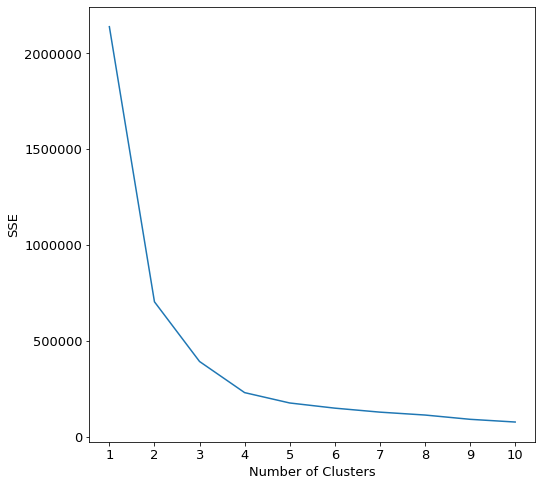

In [55]:
X_df
Kmean_committee = KMeans(n_clusters=2)
Kmean_committee.fit(X_df)
Kmean_committee.inertia_
Kmean_committee.cluster_centers_
# y_kmeans_committee = Kmean_committee.predict(X_df)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_df)
    sse.append(kmeans.inertia_)
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [56]:
X_df

,agenda_amount,Duration_minutes,day_of_week_coded,starting_formatted,district,alder,liquor,madison,plan,city,aldermanic,public,class,street,authorizing,police,dba,agent,general,new
0,7,167.917,2,2,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
1,116,588.6,2,2,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,1
2,6,129,1,2,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0
3,2,176.133,4,2,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1
4,22,278.9,1,2,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0
5,9,322.467,3,2,1,1,0,1,0,1,0,1,0,1,1,0,0,0,1,1
6,3,162.883,4,2,0,1,0,1,1,1,0,1,0,0,0,0,0,0,1,0
7,4,84.0833,2,2,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1
8,91,345.383,2,2,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1
9,38,217.717,3,2,1,0,0,1,1,1,1,1,0,1,1,1,0,0,1,1


In [57]:
meeting[meeting['Committee']=='Madison Public Library Board']

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Duration_minutes,text,note_text,day_of_week,day_of_week_coded,starting_formatted,agenda_num,agenda_amount,Committee
43,91685815937,Madison Public Library Board,5:00:00 PM,6/4/2020 16:55,6:37 PM,1:42:50,47,No,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,102.833,MADISON PUBLIC LIBRARY BOARDCity of MadisonAge...,"City of MadisonMadison, WI 53703www.cityofmad...",Thursday,4,16,,0,Madison Public Library Board
89,91611237662,Madison Public Library Board: Meeting of July ...,5:00:00 PM,7/2/2020 16:55,9:02 PM,4:07:08,208,No,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,247.133,MADISON PUBLIC LIBRARY BOARDCity of MadisonAge...,"City of MadisonMadison, WI 53703www.cityofmad...",Thursday,4,16,,0,Madison Public Library Board
105,91640551885,Madison Public Library Board: Special Meeting ...,5:00:00 PM,7/9/2020 16:29,8:00 PM,3:30:37,255,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,210.617,MADISON PUBLIC LIBRARY BOARDCity of MadisonAge...,"City of MadisonMadison, WI 53703www.cityofmad...",Thursday,4,16,,0,Madison Public Library Board
